# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [123]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [124]:
# Load in the general demographics data.
population = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_summ = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [125]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

population.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [126]:
#check the shape of the data
population.shape

(891221, 85)

In [127]:
#check the feature summary data 
feat_summ

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [128]:
# Identify missing or unknown data values and convert them to NaNs.
population_missing_data = population.copy()


In [129]:
#create a function to convert the strings in missing column to list

In [130]:
def replace_missing(data,feature_summary,col_with_missing_info):
    """
    Function takes in three arguments:
    data: The dataframe in which we want to replace missing values with Nan
    feature_summary: The dataframe which has information on the columns and the missing values in the column 
    col_with_missing_info: the name of the column in feature_summary that has the missing value info
    """
    for attribute in feature_summary['attribute']:
        missing_list = feature_summary[feature_summary['attribute']==attribute][col_with_missing_info].iloc[0].replace('[','').replace(']','').split(',')
        missing_list = [int(val) if val.lstrip('-').isnumeric() else val for val in missing_list]
    
        data[attribute].replace(to_replace=missing_list,value=np.nan, inplace=True)
    
    return data

In [131]:
#use the function to replace the missing values
population_replaced = replace_missing(population_missing_data,feat_summ,col_with_missing_info='missing_or_unknown')
population_replaced.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [132]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nulls = population_replaced.isnull().sum().sort_values(ascending=False)
nulls

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_ANTG1               116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
VERS_TYP                 111196
HEALTH_TYP               111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [133]:
#check the proportion of values that are null in each column
nulls_proportion = (nulls/population_replaced.shape[0])
nulls_proportion

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
KKK                      0.177357
REGIOTYP                 0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_ANTG1               0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
SHOPPER_TYP              0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

<Axes: >

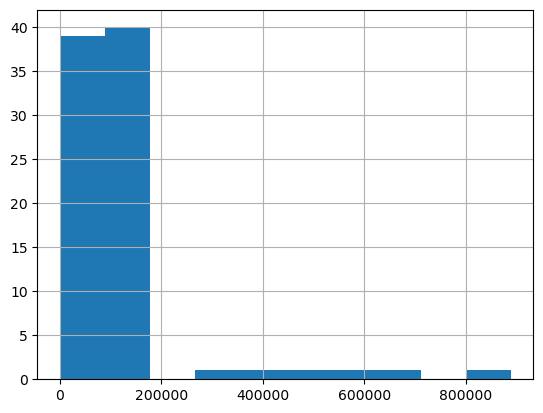

In [134]:
# Investigate patterns in the amount of missing data in each column.
nulls.hist()

In [135]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [136]:
#lets remove the columns that have more than 30% as null values 
cols_to_drop=list((nulls_proportion[nulls_proportion >= 0.3]).index)
population_replaced.drop(cols_to_drop, axis='columns', inplace=True)

In [137]:
#also drop the same cols from feat_summ
feat_new = feat_summ[~feat_summ['attribute'].isin(cols_to_drop)]
feat_new.shape

(79, 4)

In [138]:
population_replaced.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- Some columns have no missing data, while others contain a significant amount of missing data. The 'TITEL_KZ' column stands out with over 99% of its data missing.
- The 3 columns with the most missing data have categorical features
- 6 columns (TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH)have more than 30% of the data missing. These columns have been dropped

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

<Axes: >

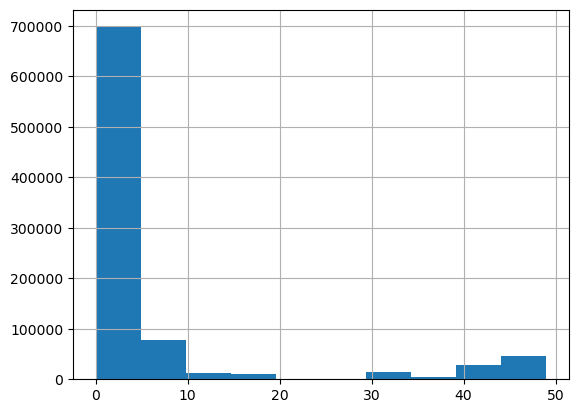

In [139]:
# How much data is missing in each row of the dataset?
population_replaced.isnull().sum(axis=1).sort_values(ascending=False).hist()


In [140]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

In [141]:
#lets follow the same 30% rule we used for the columns and set our treshold as 24 (30% of the number of columns)
below_thresh = population_replaced.drop(population_replaced[population_replaced.isnull().sum(axis=1)>24].index)
above_thresh = population_replaced.drop(population_replaced[population_replaced.isnull().sum(axis=1)<=24].index)

In [142]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [143]:
#names of cols with no missing data in the below thresh group
cols_below_thresh = list(below_thresh.isnull().sum()[below_thresh.isnull().sum()==0].index)

#names of cols with no missing data in the above thresh group
cols_above_thresh = list(above_thresh.isnull().sum()[above_thresh.isnull().sum()==0].index)

In [144]:
#randomly select 5 cols that are present in both below_thresh & above_thresh

common_columns = list(set(cols_below_thresh) & set(cols_above_thresh))

random.seed(0) 
selected_columns = random.sample(common_columns, 5)
selected_columns

['SEMIO_VERT', 'SEMIO_KRIT', 'SEMIO_TRADV', 'FINANZ_MINIMALIST', 'ANREDE_KZ']

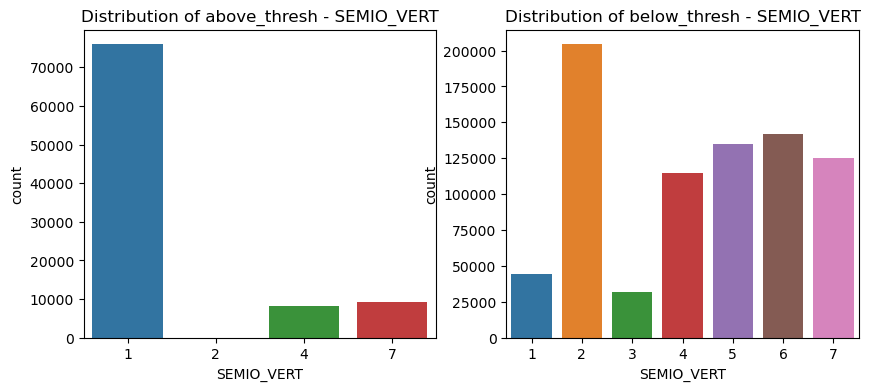

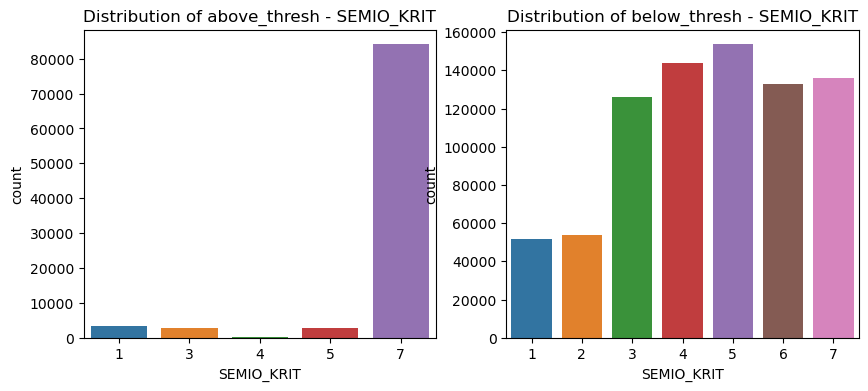

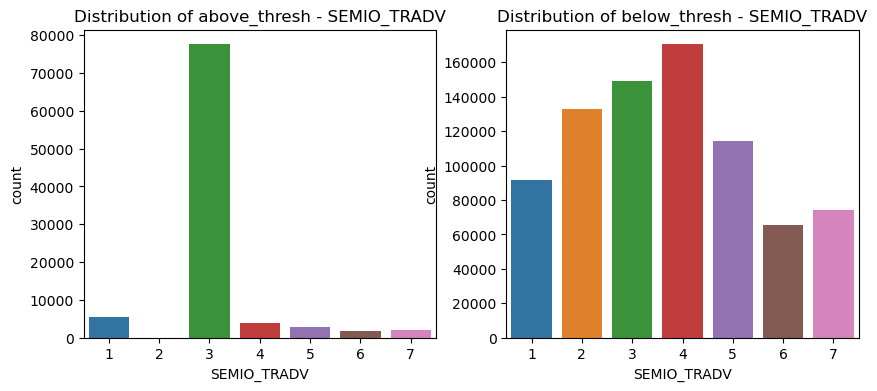

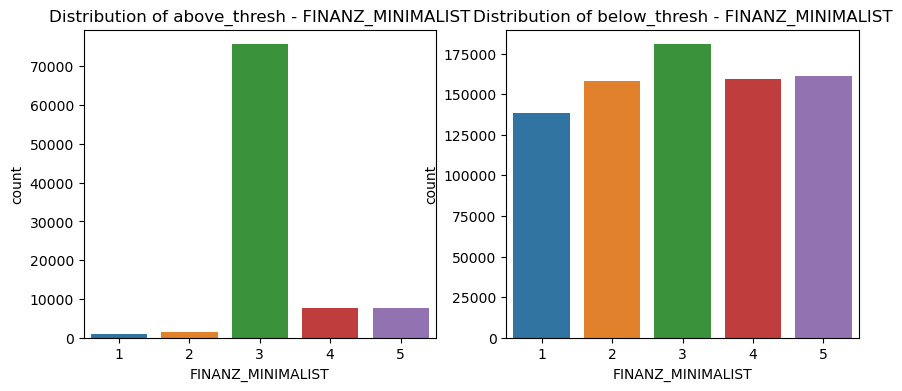

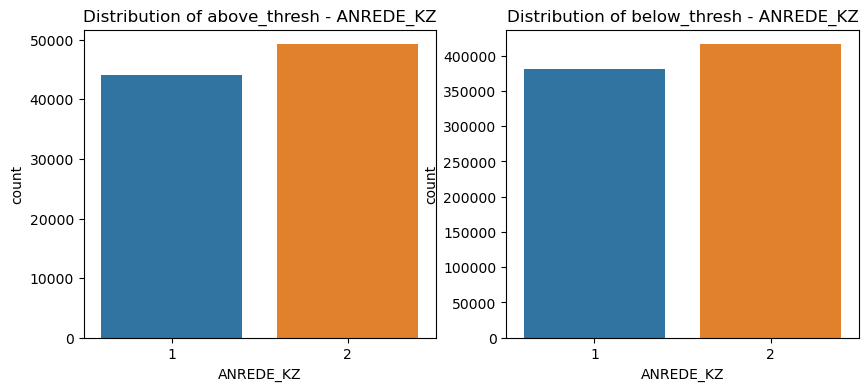

In [145]:
for col in selected_columns:

    plt.figure(figsize=(10, 4))
    ax1 = plt.subplot(1,2,1)
    sns.countplot(data = above_thresh, x = col, ax=ax1)
    ax1.set_title(f'Distribution of above_thresh - {col}')

    ax2 = plt.subplot(1,2,2)
    sns.countplot(data = below_thresh, x = col, ax=ax2)
    ax2.set_title(f'Distribution of below_thresh - {col}')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The data with lots of missing values (above_threshold of 24 columns with missing data) has a different distribution with data with less than 24 missing columns.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [146]:
# How many features are there of each data type? (note that we have removed the 6 columns with over 30% missing values

feat_new['type'].value_counts()

type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [147]:
#let's look at the no and type of values in categorical columns 

cat = list(feat_new[feat_new['type']=='categorical']['attribute'])
cat

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

We will continue analysis here with the rows that have less than 24 missing columns (below_thresh)

In [148]:
for col in cat:
    print(f'{col} has {below_thresh[col].nunique()} unique values. They are {below_thresh[col].unique()}')
    print('\n ................................................................... \n')

ANREDE_KZ has 2 unique values. They are [2 1]

 ................................................................... 

CJT_GESAMTTYP has 6 unique values. They are [ 5.  3.  2.  4.  1.  6. nan]

 ................................................................... 

FINANZTYP has 6 unique values. They are [1 6 5 2 4 3]

 ................................................................... 

GFK_URLAUBERTYP has 12 unique values. They are [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]

 ................................................................... 

GREEN_AVANTGARDE has 2 unique values. They are [0 1]

 ................................................................... 

LP_FAMILIE_FEIN has 11 unique values. They are [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]

 ................................................................... 

LP_FAMILIE_GROB has 5 unique values. They are [ 3.  1. nan  5.  2.  4.]

 ................................................................... 


In [149]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


In [150]:
# Re-encode categorical variable(s) to be kept in the analysis.

In [151]:
# We need to re encode the values in columns ANREDE_KZ and OST_WEST_KZ to 0 and 1 
below_thresh['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
below_thresh['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)


In [152]:
#we will perform one hot encoding for the multi-level features 

In [153]:
#get the list of columns with more than two unique values 
multi_level = [col for col in cat if below_thresh[col].nunique() > 2]
multi_level

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [154]:
#before one hot encoding 
below_thresh.shape[1]

79

In [155]:
below_thresh = pd.get_dummies(below_thresh, columns=multi_level)
below_thresh.shape[1]

194

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- i chose to keep the multi-level features as these features may have information that is important for our analysis

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [156]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#create a dict to store the values to be used to create new columns 
gen_mov = {1: [40,0], 2: [40,1], 3: [50,0], 4: [50,1], 5: [60,0], 6: [60,1], 7: [60,1], 8: [70,0], 9: [70,1], 10: [80,0], 11: [80,1], 12: [80,0],
13: [80,1], 14: [90,0], 15: [90,1]}

below_thresh['GENERATION'] = below_thresh['PRAEGENDE_JUGENDJAHRE'].apply(lambda val: np.nan if np.isnan(val) else gen_mov[val][0])
below_thresh['MOVEMENT'] = below_thresh['PRAEGENDE_JUGENDJAHRE'].apply(lambda val: np.nan if np.isnan(val) else gen_mov[val][1])

In [157]:
#REMOVE the PRAEGENDE_JUGENDJAHRE col
below_thresh.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [158]:
#check the no of cols - should be 195
below_thresh.shape[1]

195

In [159]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
below_thresh['CAMEO_INTL_2015'].dtype

dtype('O')

In [160]:
#create two new variables from the values in CAMEO_INTL_2015
below_thresh['WEALTH'] = below_thresh['CAMEO_INTL_2015'].str[0]
below_thresh['LIFE_STAGE'] = below_thresh['CAMEO_INTL_2015'].str[1]

In [161]:
#REMOVE the CAMEO_INTL_2015 col and check the no of columns
below_thresh.drop('CAMEO_INTL_2015', axis=1, inplace=True)
below_thresh.shape[1]

196

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I chose to keep these two mixed features - PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. From PRAEGENDE_JUGENDJAHRE, i engineered two features: 'GENERATION' & 'MOVEMENT'. the numbers in this column represented different decades and movement type and I was able to extract the decade and movement from them.  From CAMEO_INTL_2015, I engineered 'WEALTH' and 'LIFE_STAGE'. the values in this column 
had double digit, the first representing the wealth status and the second representing the life stage. i was able to use this info to create these new columns. 
I dropped the other mixed columns as I couldnt find an objective logic to disentangle the various values.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [162]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#drop the 2 cols that were just removed 
feat_new.drop
mixed = list(feat_new[feat_new['type'] == 'mixed']['attribute'])
mixed.remove('PRAEGENDE_JUGENDJAHRE')
mixed.remove('CAMEO_INTL_2015')
feat_new = feat_new[~feat_new['attribute'].isin(mixed)]
feat_new

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [163]:
cols_to_drop.extend(mixed)
cols_to_drop

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'PLZ8_BAUMAX']

In [164]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#drop all the other mixed columns 
below_thresh.drop(mixed, axis=1, inplace=True)
below_thresh.shape[1]

192

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [165]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    feat_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
    
    for attribute in feat_summary['attribute']:
        missing_list = feat_summary[feat_summary['attribute']==attribute]['missing_or_unknown'].iloc[0].replace('[','').replace(']','').split(',')
        missing_list = [int(val) if val.lstrip('-').isnumeric() else val for val in missing_list]
    
        df[attribute].replace(to_replace=missing_list,value=np.nan, inplace=True)
 
    
    # remove selected columns and rows, ...
    #remove columns in the cols_to_drop list 
    df.drop(cols_to_drop, axis=1, inplace=True)

    #drop rows that have a missing value in more than 24 columns 
    df = df.drop(df[df.isnull().sum(axis=1)>24].index)

    #re- encode values in the binary columns
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

    #perform one hot encoding for columns with more than 2 unique values
    df = pd.get_dummies(df, columns=multi_level, dtype=float)

    # re- engineer column values.
    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda val: np.nan if np.isnan(val) else gen_mov[val][0])
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda val: np.nan if np.isnan(val) else gen_mov[val][1])

    df['WEALTH'] = df['CAMEO_INTL_2015'].str[0]
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].str[1]

    #drop the two columns that were re-engineered
    df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [166]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [167]:
#lets find out how many rows in our df have at least one col with a missing value
print(f'There are {below_thresh.isnull().any(axis=1).sum()} rows with at least one missing column out of a total of {below_thresh.shape[0]} rows')

There are 174695 rows with at least one missing column out of a total of 797906 rows


This means like 25% of our data has at least one missing column. Dropping these rows may make us lose valuable info about our data. so lets use the imputer instead

In [168]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
cleaned_data = pd.DataFrame(imputer.fit_transform(below_thresh), columns=below_thresh.columns)

In [169]:
# Apply feature scaling to the general population demographics data.
scaler = RobustScaler()
scaler = scaler.fit(cleaned_data)
scaled_data = scaler.transform(cleaned_data)
scaled_df = pd.DataFrame(scaled_data, columns=cleaned_data.keys())

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

About 25% of our data has at least one missing column. Dropping these rows may make us lose valuable info about our data, so I decided to use the imputer instead and replaced missing values in each column with the mean of that column.

For scaling, I decided to standardize the features

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [170]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
data_pca = pca.fit_transform(scaled_df)


In [171]:
pca.explained_variance_ratio_

array([2.01297994e-01, 1.33565293e-01, 7.20271440e-02, 6.11136546e-02,
       5.56303162e-02, 5.06200258e-02, 3.58624478e-02, 3.39773527e-02,
       2.57768095e-02, 1.96505154e-02, 1.60484716e-02, 1.43343649e-02,
       1.23213165e-02, 1.17741178e-02, 1.04684529e-02, 1.01164419e-02,
       9.40811754e-03, 7.83090218e-03, 6.98276626e-03, 6.18347851e-03,
       5.92978358e-03, 5.52567002e-03, 5.27154273e-03, 5.06351259e-03,
       4.82723560e-03, 4.65151364e-03, 4.47474402e-03, 4.41424811e-03,
       4.35603204e-03, 4.10714503e-03, 3.93608187e-03, 3.87308190e-03,
       3.78800401e-03, 3.76543667e-03, 3.43683307e-03, 3.33673541e-03,
       3.28130116e-03, 3.09611863e-03, 3.08273886e-03, 3.00693085e-03,
       2.97753246e-03, 2.92800766e-03, 2.87299690e-03, 2.74682101e-03,
       2.65524212e-03, 2.62756383e-03, 2.61519078e-03, 2.60403185e-03,
       2.52606196e-03, 2.48994370e-03, 2.46006814e-03, 2.43553128e-03,
       2.35433292e-03, 2.32696848e-03, 2.27908037e-03, 2.19010387e-03,
      

In [172]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca, components=None):
    '''
    Returns a scree plot of the principal components vs explained variance
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    if components == None:
        components=len(pca.explained_variance_ratio_)
    index = np.arange(components)
    components_var = pca.explained_variance_ratio_[:components]
 
    plt.figure(figsize=(14, 12))
    ax = plt.subplot(211)
    cum_var = np.cumsum(components_var)
    ax.bar(index, components_var)
    ax.plot(index, cum_var)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance (%)")
    plt.title('Explained Variance by Principal Component')

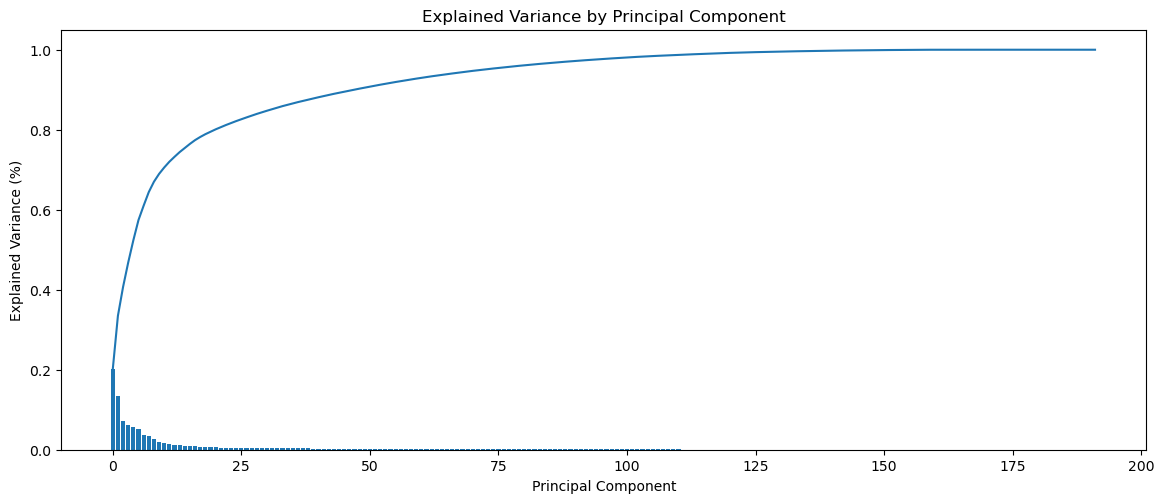

In [173]:
scree_plot(pca)

In [174]:
#Lets interpret the chart above in words
for i in np.arange(10, len(pca.explained_variance_ratio_), 10):
    print('{} components explains {}% of variance'.format(i,(pca.explained_variance_ratio_[:i].sum()) * 100))

10 components explains 68.95215523444924% of variance
20 components explains 79.49899823449482% of variance
30 components explains 84.36114097133381% of variance
40 components explains 87.82146721448882% of variance
50 components explains 90.5258064409434% of variance
60 components explains 92.77089268655078% of variance
70 components explains 94.55769508795649% of variance
80 components explains 95.97652191053717% of variance
90 components explains 97.09988173742227% of variance
100 components explains 97.98938333675467% of variance
110 components explains 98.65154596928838% of variance
120 components explains 99.1683838899209% of variance
130 components explains 99.51110392060963% of variance
140 components explains 99.74668980451995% of variance
150 components explains 99.89939838129095% of variance
160 components explains 99.99205803881543% of variance
170 components explains 100.0% of variance
180 components explains 100.0% of variance
190 components explains 100.0% of variance


In [211]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=90)
pca_data = pca.fit_transform(scaled_df)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

We can see that from 90 components, the increase in cumulative explained variance starts to reduce. 90 components explains about 97% of the variance and this seems good enough for me. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [212]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


def interpret_pca(data, pca, component_no, no_of_features):
    '''
    This function maps & visualizes the weight of a predefined Principal component for a prredefined no of features

    Input:
    data - The original dataframe which we performed pca on

    pca - the previously instantiated pca object

    component_no - the assigned no of the component which we want to visualize. i.e if we want the 5th component, component_no = 5 
    no_of_features - the no of features from the origian df which we want to visualize 
    '''
    
    comp = pd.DataFrame(np.round(pca.components_, 3), columns=data.keys()).iloc[component_no - 1]
    comp.sort_values(ascending=False, inplace=True)
    comp = pd.concat([comp.head(no_of_features), comp.tail(no_of_features)])
    
    comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(no_of_features*2, component_no),
                  figsize=(10, 6));
    plt.show()

    return comp

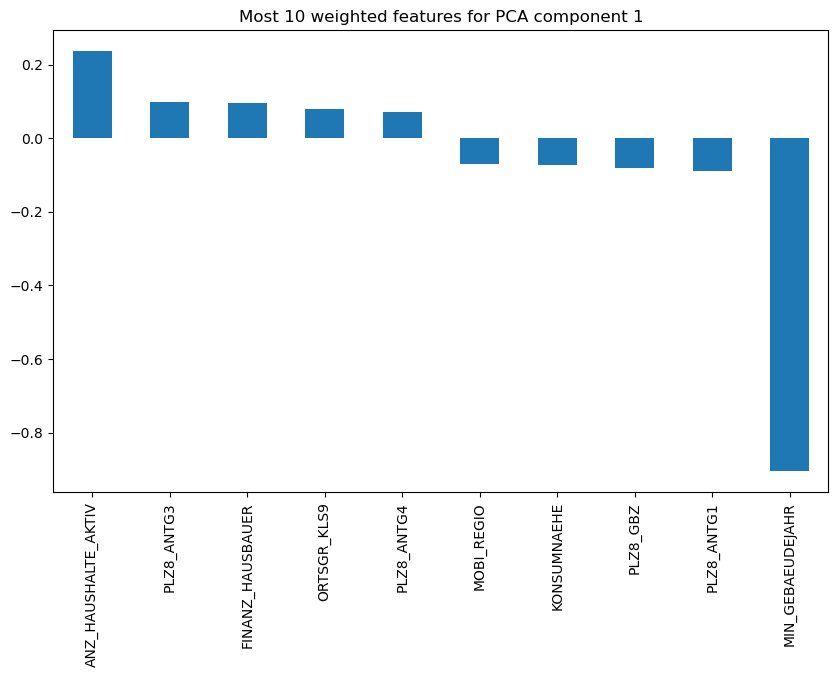

ANZ_HAUSHALTE_AKTIV    0.236
PLZ8_ANTG3             0.099
FINANZ_HAUSBAUER       0.095
ORTSGR_KLS9            0.078
PLZ8_ANTG4             0.070
MOBI_REGIO            -0.071
KONSUMNAEHE           -0.073
PLZ8_GBZ              -0.082
PLZ8_ANTG1            -0.089
MIN_GEBAEUDEJAHR      -0.905
Name: 0, dtype: float64

In [214]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pca(scaled_df, pca, 1, 5)


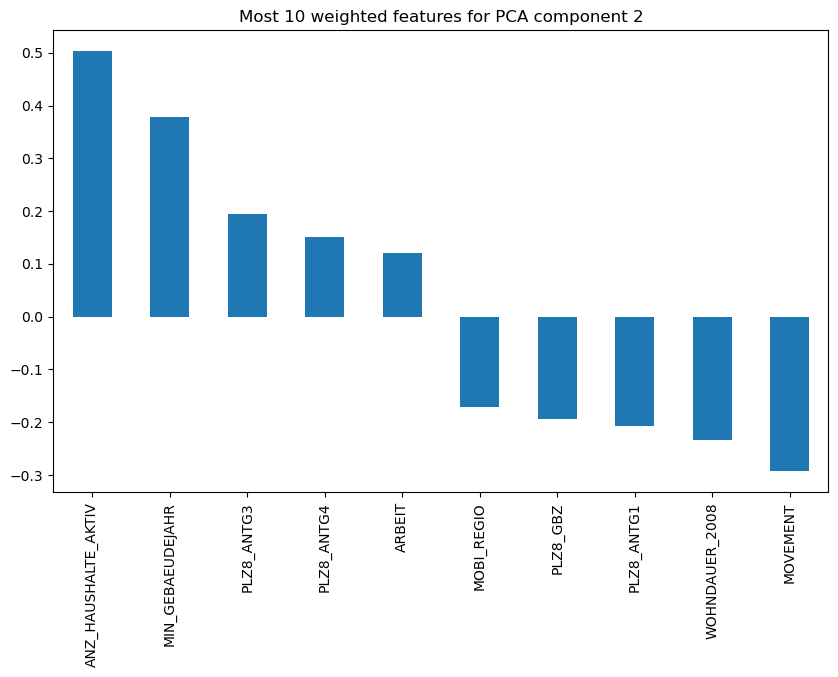

ANZ_HAUSHALTE_AKTIV    0.503
MIN_GEBAEUDEJAHR       0.379
PLZ8_ANTG3             0.194
PLZ8_ANTG4             0.151
ARBEIT                 0.120
MOBI_REGIO            -0.172
PLZ8_GBZ              -0.193
PLZ8_ANTG1            -0.208
WOHNDAUER_2008        -0.234
MOVEMENT              -0.293
Name: 1, dtype: float64

In [215]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pca(scaled_df, pca, 2, 5)

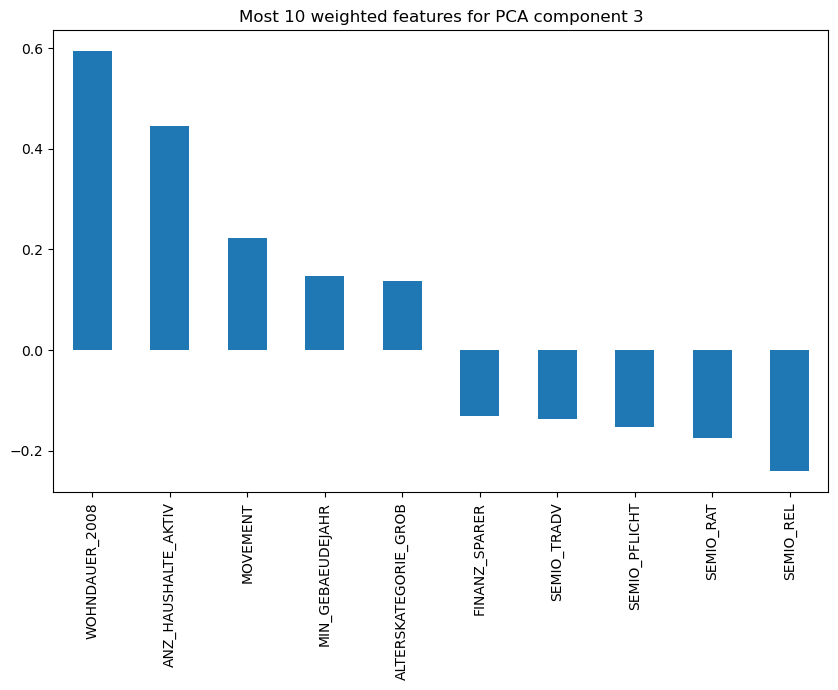

WOHNDAUER_2008          0.594
ANZ_HAUSHALTE_AKTIV     0.445
MOVEMENT                0.223
MIN_GEBAEUDEJAHR        0.147
ALTERSKATEGORIE_GROB    0.138
FINANZ_SPARER          -0.131
SEMIO_TRADV            -0.138
SEMIO_PFLICHT          -0.153
SEMIO_RAT              -0.174
SEMIO_REL              -0.241
Name: 2, dtype: float64

In [216]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_pca(scaled_df, pca, 3, 5)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

For principal component 1: This component looks for features like the no of households in the building, the size of families in the region and financial topology. These features are very significant in this pc

For principal component 2: This component also looks out features like the no of households in the building and the length of residence

For principal component 3: This component also looks out for the length of residence, personality and financial topology.

the magnitude of the value is what is important here, a high magnitude indicates a strong presence of the feature in the principal component. 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [217]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
def calc_kmeans_score(data, no_of_clusters, iterations=50):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataframe you want to perform cluster analysis on
        no_of_clusters - the number of clusters you want
        iterations - the no of iterations for kmeans
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=no_of_clusters, max_iter=iterations) 

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Text(0.5, 1.0, 'SSE vs. No of clusters')

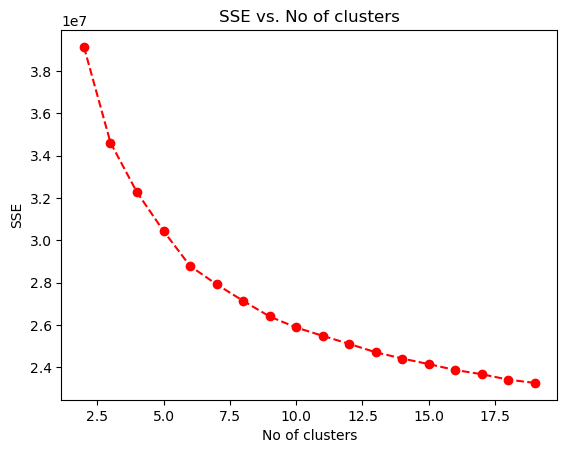

In [218]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

scores = []
no_clusters = np.arange(2,20)

for no in no_clusters:
    scores.append(calc_kmeans_score(pca_data, no))

plt.plot(no_clusters, scores, linestyle='--', marker='o', color='r');
plt.xlabel('No of clusters');
plt.ylabel('SSE');
plt.title('SSE vs. No of clusters')

In [219]:
for num,val in zip(scores, no_clusters):
    print(f'{val} clusters - {num}')

2 clusters - 39132067.32617867
3 clusters - 34613815.91719169
4 clusters - 32266774.035157785
5 clusters - 30442197.484437145
6 clusters - 28789783.333856836
7 clusters - 27924046.58610674
8 clusters - 27145019.560143687
9 clusters - 26404809.211411495
10 clusters - 25886385.55253169
11 clusters - 25493013.145481832
12 clusters - 25110546.108155794
13 clusters - 24715753.587612413
14 clusters - 24420936.565817818
15 clusters - 24156846.808136497
16 clusters - 23878083.034850843
17 clusters - 23679683.926367134
18 clusters - 23423741.35989336
19 clusters - 23268575.014126636


In [220]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# cluster predictions for the general population demographics data.
np.random.seed(1)
kmeans = KMeans(n_clusters=13)
model = kmeans.fit(pca_data)
prediction_pop = model.predict(pca_data)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [221]:
prediction_pop_df = pd.DataFrame(prediction_pop, columns = ['cluster'])

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

The scree plot shows that there is no much improvement in the score after K=13.Therefore, I have chosen k = 13 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [222]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [223]:
customers.shape

(191652, 85)

In [224]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [225]:
for col in customers.columns:
    print(col)

AGER_TYP
ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GEBURTSJAHR
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
KK_KUNDENTYP
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG

In [226]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned_customers = clean_data(customers)


In [227]:
cleaned_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,0,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1,3
2,4.0,1,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,1,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0.0,1.0,0.0,0.0,0

In [228]:
cleaned_customers.shape

(141721, 191)

The 'GEBAEUDETYP_5.0' column is missing from the customers dataset. lets add this col to the dataset and set all values to 0 

In [229]:
cleaned_customers['GEBAEUDETYP_5.0']=0

Reorder the columns in customers dataset to be the same as population data 

In [230]:
cleaned_customers = cleaned_customers.reindex(columns=cleaned_data.columns)

In [231]:
cleaned_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,0,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1,3
2,4.0,1,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,1,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0

In [232]:
# Check how many rows (if any) have missing values
cleaned_customers.isna().any().sum()

34

In [233]:
#let's use the already fit imputer to replace the null values with the mean of each col 
cleaned_cust = pd.DataFrame(imputer.transform(cleaned_customers), columns=cleaned_customers.columns)

In [234]:
# Standardize the data witht he scaler that was fit on the train set 
scaled_customers = scaler.transform(cleaned_cust)

In [235]:
# Apply PCA to customer data
customers_pca = pca.transform(scaled_customers)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [236]:
# Cluster predictions for customer data 
customers_clustered = model.predict(customers_pca)

In [237]:
customers_clustered_df = pd.DataFrame(customers_clustered, columns = ['cluster'])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [238]:
population_proportion = []
customers_proportion = []
clusters = np.arange(0, 13)

for cluster in clusters:
    population_proportion.append((prediction_pop_df['cluster'] == cluster).sum() * 100 / len(prediction_pop_df))
    customers_proportion.append((customers_clustered_df['cluster'] == cluster).sum() * 100 / len(customers_clustered_df))

final_df = pd.DataFrame({'cluster': clusters, 'population': population_proportion, 'customers':customers_proportion})
final_df

,cluster,population,customers
0,0,12.407101,9.285850
1,1,2.841939,2.263602
2,2,7.395859,1.241171
3,3,5.132685,4.614701
4,4,0.418345,0.330932
5,5,11.073986,9.405099
6,6,10.253463,1.127568
7,7,5.744662,9.478482
8,8,6.947435,1.771791
9,9,9.074252,1.766146


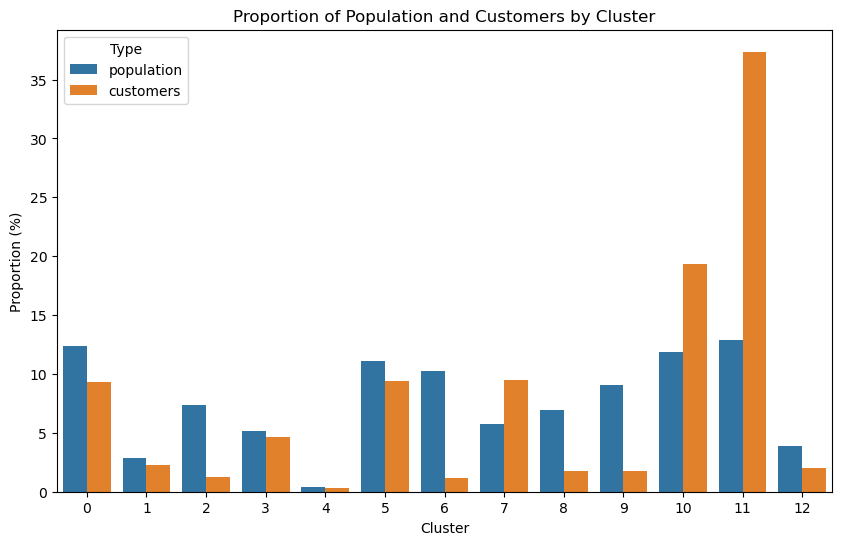

In [239]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

melted_df = final_df.melt(id_vars='cluster', value_vars=['population', 'customers'], var_name='Type', value_name='Proportion')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='Proportion', hue='Type', data=melted_df)
plt.title('Proportion of Population and Customers by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion (%)')
plt.legend(title='Type')
plt.show()

In [203]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?


cluster 11 is over represented in the customers data 

In [240]:
centroid_cluster_11 = pd.Series(kmeans.cluster_centers_[11]).sort_values(ascending=False)
centroid_cluster_11

3     2.378004
2     1.292399
7     0.349150
9     0.325070
10    0.168011
23    0.112925
16    0.097218
20    0.063753
27    0.057821
39    0.045422
50    0.041418
46    0.039517
31    0.034122
52    0.031468
32    0.021326
43    0.019502
81    0.016407
17    0.015991
58    0.014552
78    0.012569
26    0.012470
30    0.009223
41    0.008471
49    0.008319
85    0.005946
74    0.005751
76    0.005050
69    0.004697
70    0.003875
80    0.002777
64    0.002656
65    0.001023
89    0.000742
66    0.000444
87    0.000418
72    0.000407
59    0.000357
68    0.000199
84    0.000103
62   -0.000437
63   -0.000509
86   -0.000692
67   -0.000967
82   -0.002531
79   -0.002757
88   -0.003027
35   -0.003675
83   -0.003795
57   -0.003796
61   -0.003930
71   -0.004605
75   -0.004688
28   -0.005491
44   -0.005520
34   -0.006004
5    -0.006535
25   -0.007158
73   -0.008361
56   -0.010321
53   -0.010472
48   -0.011194
77   -0.013625
60   -0.013698
8    -0.021228
38   -0.023736
15   -0.023762
33   -0.02

In [241]:
#pca component 3 is the highest. now lets investigate what features are highlighted in this component

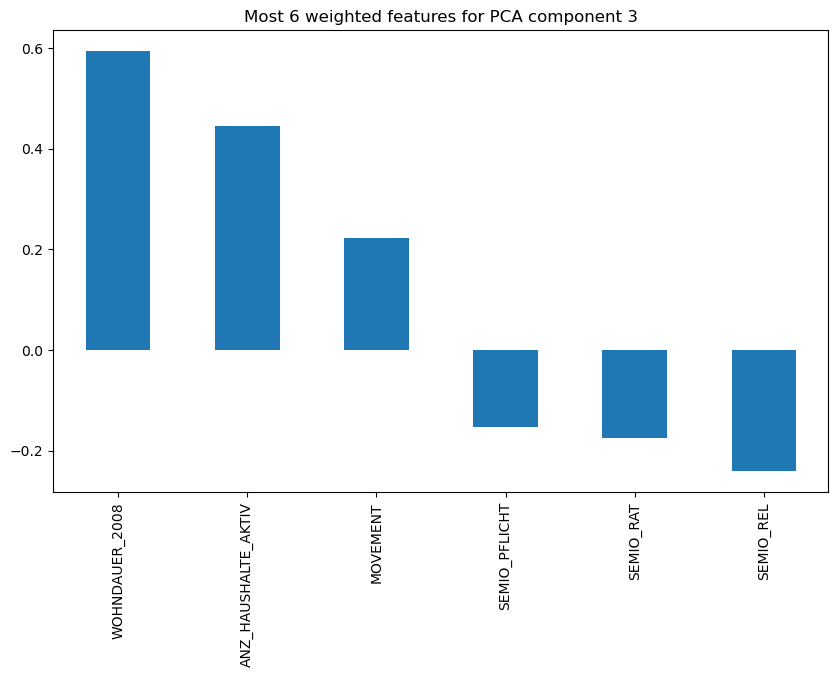

WOHNDAUER_2008         0.594
ANZ_HAUSHALTE_AKTIV    0.445
MOVEMENT               0.223
SEMIO_PFLICHT         -0.153
SEMIO_RAT             -0.174
SEMIO_REL             -0.241
Name: 2, dtype: float64

In [242]:
interpret_pca(cleaned_customers, pca, 3, 3)

As indicated above, the people in this cluster are mostly people with dutiful,rational and religous. recent movers who have lived in residence for less than a year

In [207]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster 6 is under represented in the customers data 

In [243]:
centroid_cluster_6 = pd.Series(kmeans.cluster_centers_[6]).sort_values(ascending=False)
centroid_cluster_6

5     2.126834
1     1.956611
0     1.848824
13    0.141738
7     0.139673
10    0.117743
9     0.083252
23    0.076886
44    0.049984
20    0.043504
26    0.043441
41    0.043266
25    0.043248
30    0.041880
36    0.037043
33    0.036508
52    0.036014
46    0.034303
62    0.030245
65    0.029725
15    0.028033
69    0.026222
71    0.023551
28    0.022090
59    0.020651
58    0.019184
74    0.018720
63    0.016569
83    0.015940
70    0.014241
50    0.013779
49    0.013723
29    0.013455
42    0.011463
16    0.011462
67    0.010954
88    0.010167
85    0.007709
43    0.007058
86    0.006525
89    0.006387
80    0.003112
79    0.002895
48    0.002442
72    0.002213
38    0.000943
84    0.000604
35   -0.000513
68   -0.001127
76   -0.001406
57   -0.002273
78   -0.004263
73   -0.006609
75   -0.007779
56   -0.008000
22   -0.008677
82   -0.010769
24   -0.011764
64   -0.012798
51   -0.015269
61   -0.016602
55   -0.017269
60   -0.017959
81   -0.018904
32   -0.020004
40   -0.021916
77   -0.02

In [209]:
#pca component 5 is the highest. Now lets investigate what features are highlighted in this component

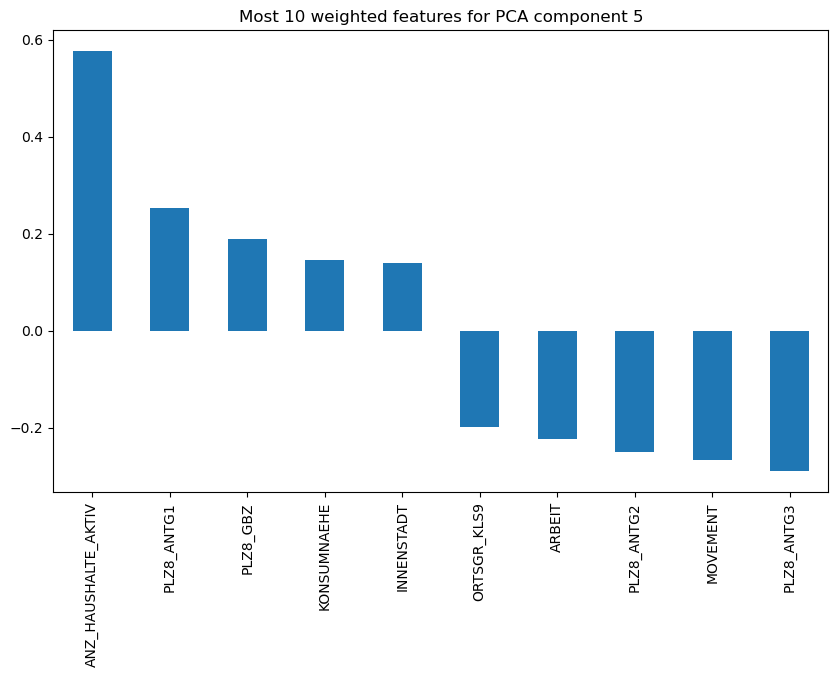

ANZ_HAUSHALTE_AKTIV    0.576
PLZ8_ANTG1             0.252
PLZ8_GBZ               0.189
KONSUMNAEHE            0.145
INNENSTADT             0.140
ORTSGR_KLS9           -0.199
ARBEIT                -0.223
PLZ8_ANTG2            -0.250
MOVEMENT              -0.266
PLZ8_ANTG3            -0.290
Name: 4, dtype: float64

In [244]:
interpret_pca(cleaned_customers, pca, 5, 5)

As indicated above, the people in this cluster are mostly people with small family homesand  live in a region with less than 60 buildings

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

segments of people popular in the mail order company - recent movers who have a dutiful, rational and religous personality.
segments of people unpopular in the mail order company - people with small family homes and  live in a small community and region with less than 60 buildings

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.